This notebook performs a comprehensive becnhmark suit for the inference procedure for the double pendulum system using the RxInfer framework.

_Author: Dmitry Bagaev_

In [1]:
using DrWatson

In [2]:
@quickactivate "RxInferThesisExperiments"

In [3]:
using RxInferThesisExperiments, RxInfer, StaticArrays, Plots, PGFPlotsX, LaTeXStrings
using LinearAlgebra, StableRNGs, Random, BenchmarkTools, ColorSchemes, Dates, DataFrames

[ Info: Precompiling RxInferThesisExperiments [45155ac3-0a9e-41cf-b3f8-8307b1a2d51a]


In [4]:
const bfolder = datadir("lds", "rxinfer")

"/Users/bvdmitri/.julia/dev/thesis/data/lds/rxinfer"

In [5]:
# Pregenerate paths for benchmark data
mkpath(bfolder);

In [6]:
# Include the model specification
include(srcdir("models", "rxinfer", "rotating.jl"));

In [7]:
function run_benchmark(params)
    @unpack T, d, seed = params
    
    environment = RotatingTracking(d; rng = StableRNG(seed))
    
    states, observations = rand(StableRNG(seed), environment, T);
    model    = rotating(T, environment.A, environment.B, environment.P, environment.Q) 
    result   = inference(model = model, data = (y = observations, ));
    e_states = extract_posteriors(T, result)
    amse     = compute_amse(states, e_states)
    
    benchmark_modelcreation = @benchmark RxInfer.create_model(
        rotating($T, $(environment.A), $(environment.B), $(environment.P), $(environment.Q))
    )
    
    benchmark_inference = @benchmark inference(model = model, data = (y = observations, )) setup=begin
        model = rotating($T, $(environment.A), $(environment.B), $(environment.P), $(environment.Q))
        states, observations = rand(StableRNG($seed), $environment, $T);
    end
    
    emse = compute_emse(seed) do _seed
        local environment = RotatingTracking(d; rng = StableRNG(_seed))
        local states, observations = rand(StableRNG(_seed), environment, T);
        local model    = rotating(T, environment.A, environment.B, environment.P, environment.Q) 
        local result   = inference(model = model, data = (y = observations, ));
        local e_states = extract_posteriors(T, result)
        return compute_amse(states, e_states)
    end
    
    output = @strdict T d seed states e_states observations amse emse benchmark_modelcreation benchmark_inference
    
    return output
end

run_benchmark (generic function with 1 method)

In [8]:
# Here we create a list of parameters we want to run our benchmarks with
benchmark_params = dict_list(Dict(
    "T"    => [ 10, 20, 30 ],
    "d"    => [ 2, 3, 4 ],
    "seed" => [ 42 ]
));

In [9]:
# First run maybe slow, you may track the progress in the terminal
# Subsequent runs will not create new benchmarks 
# but will reload it from data folder
benchmarks = map(benchmark_params) do params
    result, _ = produce_or_load(run_benchmark, bfolder, params; tag = false, force = false)
    return result
end;

In [11]:
benchmarks_table = sort(prepare_benchmarks_table(bfolder), [ :T ])

[ Info: Scanning folder /Users/bvdmitri/.julia/dev/thesis/data/lds/rxinfer for result files.
[ Info: Added 9 entries.


Row,T,seed,amse,emse,d,inference,creation
,Int64?,Int64?,Float64?,Float64?,Int64?,Tuple…?,Tuple…?
1,10,42,2.86929,3.0056,2,"(478039.0, 6.01472e5, 0.0)","(268252.0, 3.27595e5, 0.0)"
2,10,42,6.20435,5.05071,3,"(495958.0, 6.61558e5, 0.0)","(271351.0, 3.36511e5, 0.0)"
3,10,42,8.26762,7.27321,4,"(503738.0, 6.21188e5, 0.0)","(281630.0, 3.41754e5, 0.0)"
4,20,42,2.39577,2.8861,2,"(872111.0, 1.09723e6, 0.0)","(544051.0, 6.85527e5, 0.0)"
5,20,42,5.79446,4.75019,3,"(898363.0, 1.14944e6, 0.0)","(545144.0, 6.72641e5, 0.0)"
6,20,42,9.47466,6.80874,4,"(902094.0, 1.17514e6, 0.0)","(543943.0, 6.68297e5, 0.0)"
7,30,42,2.53304,2.82393,2,"(1.25838e6, 1.66868e6, 0.0)","(822724.0, 9.89953e5, 0.0)"
8,30,42,5.46539,4.71851,3,"(1.30129e6, 1.68622e6, 0.0)","(820213.0, 1.04938e6, 0.0)"
9,30,42,9.16515,6.78131,4,"(1.31446e6, 1.7064e6, 0.0)","(808137.0, 1.04167e6, 0.0)"


# Extra plots

In [14]:
pgfplotsx()

Plots.PGFPlotsXBackend()

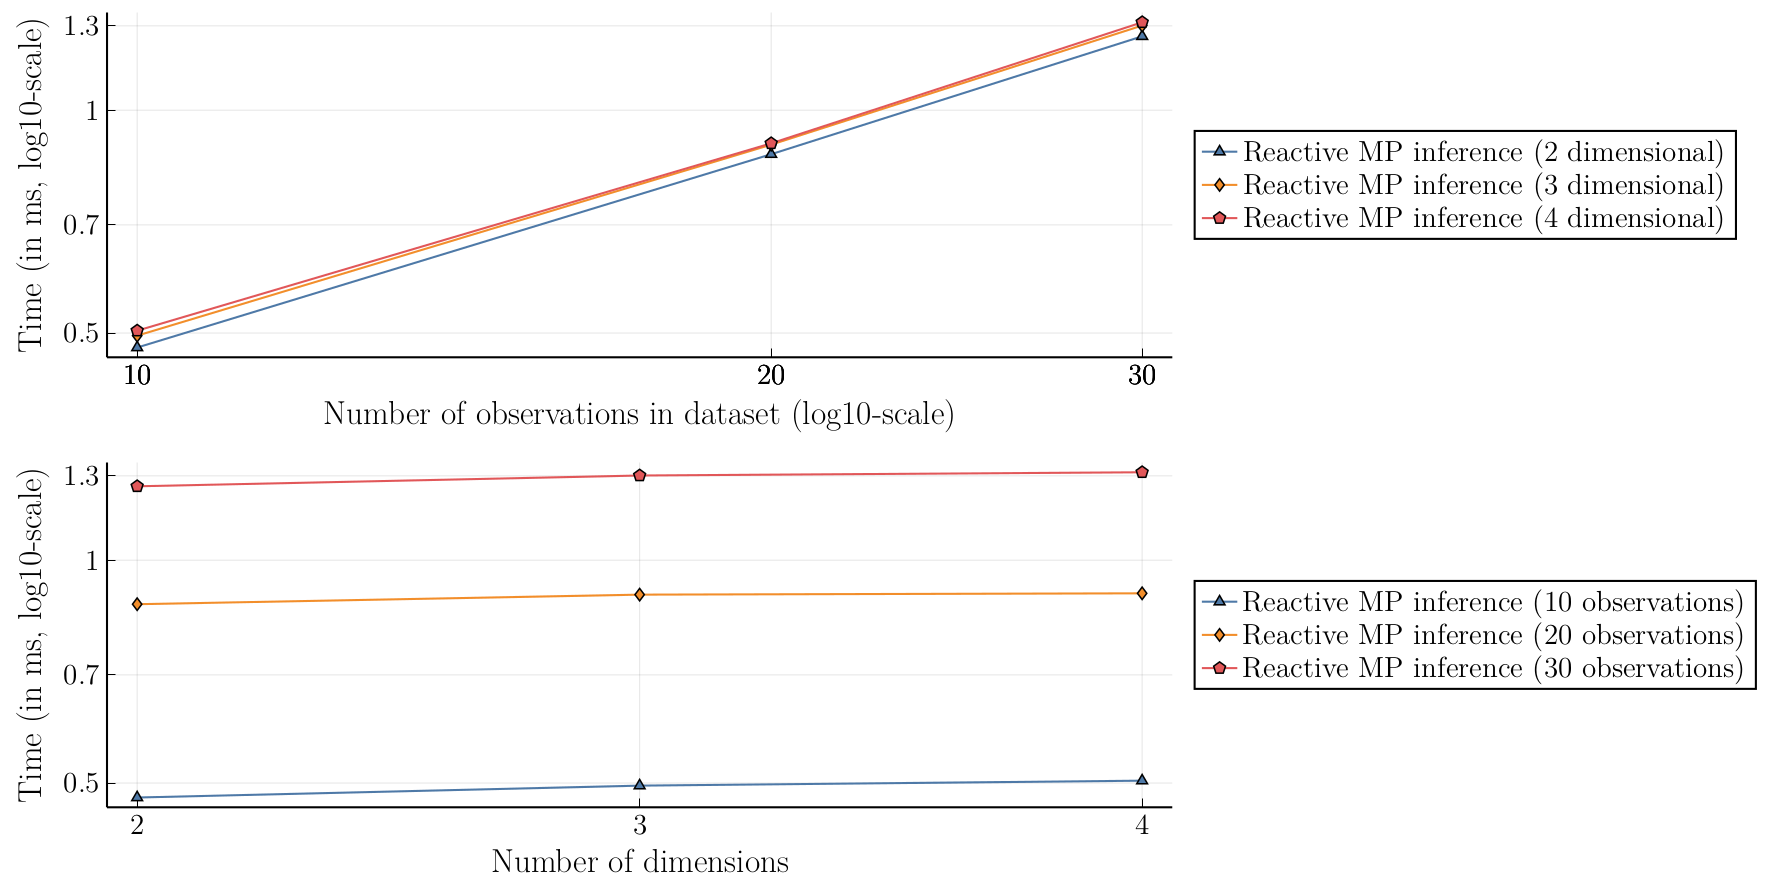

In [29]:
# `plotting`range
colors = ColorSchemes.tableau_10

# Some default settings for plotting
pfontsettings = (
    titlefontsize=18,
    guidefontsize=16,
    tickfontsize=14,
    legendfontsize=14,
    legend = :outerright,
    legend_font_halign = :left,
    size = (800, 300)
)

p1xticks = (benchmarks_table.T, string.(benchmarks_table.T))

p1yticks = (
    [ 0.01, 0.1, 0.3, 0.5, 0.7, 1, 1.3, 1.5, 2, 3 ], 
    [ "0.01", "0.1", "0.3", "0.5", "0.7", "1", "1.3", "1.5", "2", "3" ]
)

p1 = plot(
    xlabel = "Number of observations in dataset (log10-scale)", 
    ylabel = "Time (in ms, log10-scale)"; 
    xscale = :log10,
    yscale = :log10,
    xticks = p1xticks,
    yticks = p1yticks,
    pfontsettings...
)

nd = [ 2, 3, 4 ];
mshapes = [ :utriangle, :diamond, :pentagon ]

for (index, (mshape, d)) in enumerate(zip(mshapes, nd))
    filtered = filter((r) -> r["d"] == d, benchmarks_table)
    sorted      = sort(filtered, [ :T ])
    range       = map(f -> f["T"], eachrow(sorted))
    t_inference = map(f -> to_ms(f["inference"][1] - f["inference"][3]), eachrow(sorted))
    
    plot!(p1, range, t_inference, label = "Reactive MP inference ($d dimensional)", marker = mshape, color = colors[index])
end

##

p2xticks = (
    [ 2, 3, 4 ],
    string.([ 2, 3, 4 ])
)

p2yticks = (
    [ 0.01, 0.1, 0.3, 0.5, 0.7, 1, 1.3, 1.5, 2, 3 ], 
    [ "0.01", "0.1", "0.3", "0.5", "0.7", "1", "1.3", "1.5", "2", "3" ]
)

p2 = plot(
    xlabel = "Number of dimensions", 
    ylabel = "Time (in ms, log10-scale)"; 
    yscale = :log10,
    xticks = p2xticks,
    yticks = p2yticks,
    pfontsettings...
)

Ts = [ 10, 20, 30 ];
mshapes = [ :utriangle, :diamond, :pentagon, :circle ]

for (index, (mshape, T)) in enumerate(zip(mshapes, Ts))
    filtered = filter((r) -> r["T"] == T, benchmarks_table)
    sorted      = sort(filtered, [ :d ])
    range       = map(f -> f["d"], eachrow(sorted))
    t_inference = map(f -> to_ms(f["inference"][1] - f["inference"][3]), eachrow(sorted))
    
    plot!(p2, range, t_inference, label = "Reactive MP inference ($T observations)", marker = mshape, color = colors[index])
end

plot(p1, p2, size = (800, 600), layout = @layout([ a; b ]))

# Versions

In [11]:
versioninfo()

Julia Version 1.9.0
Commit 8e630552924 (2023-05-07 11:25 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin22.4.0)
  CPU: 12 × Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, skylake)
  Threads: 2 on 12 virtual cores


In [12]:
] status

Project RxInferThesisExperiments v1.0.0
Status `~/.julia/dev/thesis/Project.toml`
  [b5ca4192] AdvancedVI v0.2.3
  [6e4b80f9] BenchmarkTools v1.3.2
  [76274a88] Bijectors v0.12.4
  [35d6a980] ColorSchemes v3.21.0
  [a93c6f00] DataFrames v1.5.0
  [31c24e10] Distributions v0.25.95
  [634d3b9d] DrWatson v2.12.5
  [442a2c76] FastGaussQuadrature v0.5.1
  [9fc3f58a] ForneyLab v0.12.0
  [f6369f11] ForwardDiff v0.10.35
  [14197337] GenericLinearAlgebra v0.3.11
  [19dc6840] HCubature v1.5.1
  [7073ff75] IJulia v1.24.0
  [b964fa9f] LaTeXStrings v1.3.0
  [bdcacae8] LoopVectorization v0.12.159
  [3bd65402] Optimisers v0.2.18
  [8314cec4] PGFPlotsX v1.6.0
  [e4faabce] PProf v2.2.2
  [91a5bcdd] Plots v1.38.15
  [92933f4c] ProgressMeter v1.7.2
  [37e2e3b7] ReverseDiff v1.14.6
  [86711068] RxInfer v2.11.0
  [860ef19b] StableRNGs v1.0.0
  [aedffcd0] Static v0.8.7
  [90137ffa] StaticArrays v1.5.25
⌅ [2913bbd2] StatsBase v0.33.21
  [4c63d2b9] StatsFuns v1.3.0
  [fce5fe82] Turing v0.25.1
  [37e2e46d] Line